## Week 3 Assignment 
### Rent Burden in Los Angeles County by Census Tract
#### Miles Cressy

The data pulled from census data (Gross Rent as a Percentage of Household Income) has been cleaned prior to import. The original data contains 4 columns which represent percentages of household income spent toward rent (Less than 10%, 10-29%, 30-49%, and 50% and above). Only the last two categories were retained, added together and represented as a percentage of the total population of renters in the census tract. 30% and above was the threshold as defined by HUD's definition for rent burden. This data was then combined with additional census tract data including total population counts and renter occupied households broken down by race. This notebook serves as a preliminary investigation of the linkages that inform rent burden percentages and minority communities across LA county.

In [228]:
# standard data manipulation
import pandas as pd

# geospatial data manipulation/visualization
import geopandas as gpd

# advanced graph visualization
import seaborn as sns
import matplotlib.pyplot as plt

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [229]:
# import rent burden csv file
df = pd.read_csv('data/rent_burden_ct_1.csv')

### Exploratory Data Analysis

In [230]:
# obtain summary statistics for rent burden values
df.describe()

,Geo_FIPS,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
count,2.498000e+03,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.00000,2498.000000
mean,6.037404e+09,719.328263,325.362690,83.418335,6.713771,91.768615,1.921537,146.548439,63.594876,211.889111,309.367894,4011.06285,0.527759
std,2.311478e+05,495.157153,323.090646,139.218466,13.118913,139.523622,10.423139,145.650734,64.435505,304.165094,252.803726,1470.99188,0.149498
min,6.037101e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,6.037209e+09,345.000000,117.000000,0.000000,0.000000,6.000000,0.000000,32.000000,15.250000,21.000000,104.000000,2993.25000,0.450224
50%,6.037403e+09,640.000000,225.500000,33.000000,0.000000,41.000000,0.000000,102.000000,49.000000,93.500000,250.500000,3933.00000,0.539045
75%,6.037552e+09,996.500000,426.000000,104.000000,9.000000,120.000000,0.000000,219.000000,92.000000,273.750000,474.750000,4954.00000,0.626999
max,6.037990e+09,4790.000000,3474.000000,1218.000000,108.000000,1442.000000,323.000000,816.000000,536.000000,3317.000000,1326.000000,13830.00000,1.000000


- Observations where total populations are 0 are most likely industrial or environmental areas. These will not be particularly helpful for our analysis but we will retain these data points for the purposes of our analyses.
- Observations where rent_burden = 1 is not implausible but may require additional investigation to see if these data points are relevant.

In [231]:
# check to see if we have any missing values
df.isna().sum()

Geo_FIPS                 0
total_housing_units      0
white_alone              0
black_alone              0
american_indian_alone    0
asian_alone              0
native_hawaiian_alone    0
other                    0
two_or_more              0
white_alone_not_hisp     0
hispanic                 0
total_pop                0
rent_burden              0
dtype: int64

In [232]:
# check to see number of observations where rent burden values seem unusual
print(df[df['rent_burden'] == 0].value_counts().sum())
print(df[df['total_pop'] == 0].value_counts().sum())
print(df[df['rent_burden'] == 1].value_counts().sum())

40
20
8


It is likely where rent burden values are 0, the census tract has a total population of 0. Let's investigate what accounts for the remaining 20 observations where rent burden is 0 but the total population is a non-zero value. 

In [233]:
# isolate observations where rent burden is 0 but total_pop has a non-zero value.
df[(df['rent_burden'] == 0) & (df['total_pop'] != 0)]

,Geo_FIPS,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
117,6037115103,5,0,0,0,0,0,5,0,0,5,3037,0.0
359,6037139705,32,32,0,0,0,0,0,0,19,13,3995,0.0
371,6037141500,31,31,0,0,0,0,0,0,31,0,3006,0.0
919,6037262303,28,28,0,0,0,0,0,0,28,0,2817,0.0
938,6037265301,0,0,0,0,0,0,0,0,0,0,13830,0.0
1221,6037402404,4,4,0,0,0,0,0,0,0,4,2513,0.0
1453,6037460001,35,35,0,0,0,0,0,0,35,0,1843,0.0
1502,6037464101,48,22,0,0,26,0,0,0,22,0,2179,0.0
1574,6037500204,100,12,0,88,0,0,0,0,12,0,2287,0.0
2058,6037578100,0,0,0,0,0,0,0,0,0,0,2361,0.0


<AxesSubplot: xlabel='rent_burden'>

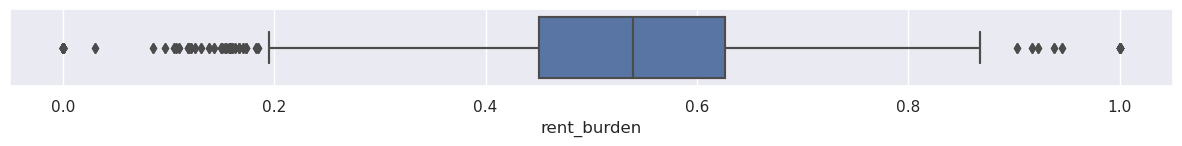

In [234]:
# observe outliers for the distribution
plt.subplots(figsize=(15, 1))
sns.boxplot(df, x='rent_burden')
sns.boxplot(df, x='rent_burden')

In [235]:
# create dictionary of average renter-occupied households by race across all LA census tracts
dict_race = {
    'white_alone' : df.white_alone.mean(),
    'hispanic' : df.hispanic.mean(),
    'white_alone_not_hisp' : df.white_alone_not_hisp.mean(),
    'other' : df.other.mean(),
    'asian_alone' : df.asian_alone.mean(),
    'black_alone' : df.black_alone.mean(),
    'two_or_more' : df.two_or_more.mean(),
    'american_indian_alone' : df.american_indian_alone.mean(),
    'native_hawaiian_alone' : df.native_hawaiian_alone.mean()
}

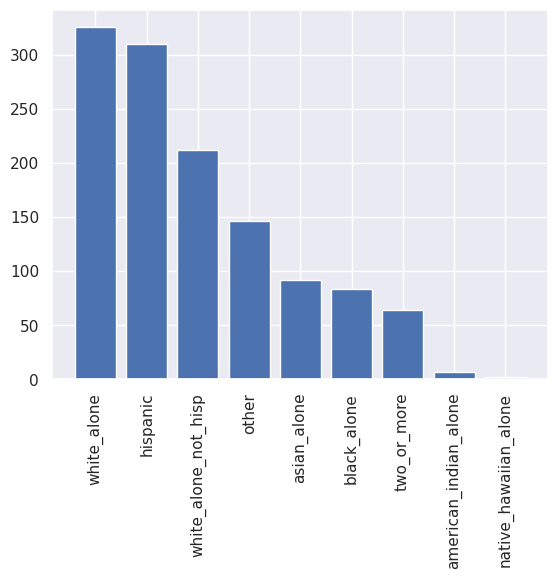

In [236]:
# create bar chart to visualize above
bar_race = plt.bar(range(len(dict_race)), list(dict_race.values()), align='center')
bar_race = plt.xticks(range(len(dict_race)), list(dict_race.keys()), rotation = 90)

The above gives us a general breakdown of renter's race across Los Angeles County - it's pretty much expected based on prior knowledge of demography in LA.

Text(0.537759214063651, 273, '-------- Mean: 54%')

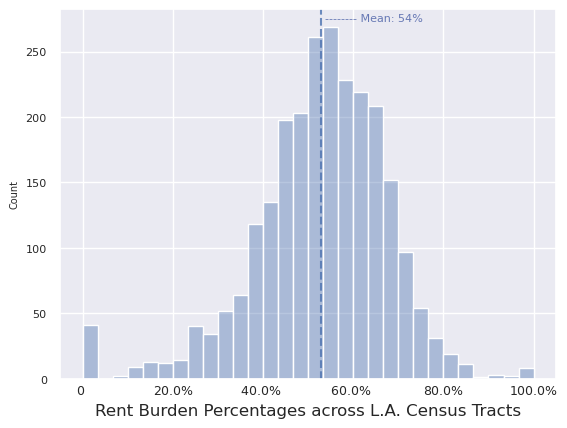

In [237]:
# lets get an idea as to the distribution of rent burden values across LA 

# set visual style
sns.set(style="darkgrid")

# create plot
histplot = sns.histplot(data=df, x='rent_burden', alpha = .4, bins =30)

# edit labels
histplot.set_xticks([0,.2,.4,.6,.8,1.0])
histplot.set_xticklabels(labels = ['0 ', '20.0%', '40.0% ', '60.0% ', '80.0%', '100.0%'], fontsize = 9, y = .02)
plt.yticks(fontsize=8)
plt.ylabel('Count', fontsize = 7)
plt.xlabel('Rent Burden Percentages across L.A. Census Tracts')

# add mean vertical line and text
histplot.axvline(x = df.rent_burden.mean(), linewidth = 2, alpha = .8, ls = '--', lw = 1.5)
histplot.text(x = df.rent_burden.mean() + .01,
         y = 273, 
         s = '-------- Mean: 54%', 
         color = [102/255, 120/255, 180/255],
         weight = 'normal', 
         fontsize = 8)

The correlation between White Renter Households and Rent Burden is 0.03179379756714936
The correlation between Black Renter Households and Rent Burden is 0.14769047296906557
The correlation between Black Renter Households and Rent Burden is 0.26417136306594624


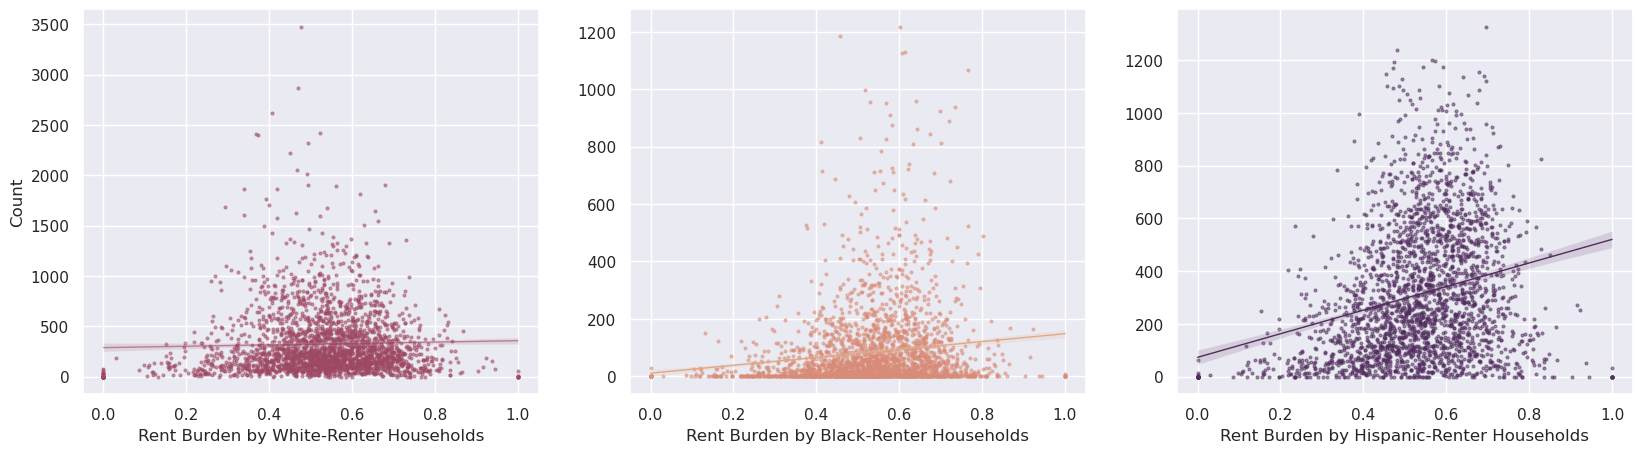

In [238]:
#lets take a look at the correlation between the race of renter-occupied households and the percentages of rent burden for the census tract

# set subplots
fig, axes = plt.subplots(1, 3, figsize = (20, 5))

# create regression plots
scatter1 = sns.regplot(ax = axes[0], data=df, x= 'rent_burden', y= 'white_alone', scatter_kws={"color": [158/255,73/255,99/255], "s": 4, "alpha" : .5 }, line_kws={'linewidth':1,'alpha':.6, "color": [158/255,73/255,99/255]})
scatter2 = sns.regplot(ax = axes[1], data=df, x= 'rent_burden', y= 'black_alone', scatter_kws={"color": [216/255,139/255,118/255], "s": 4, "alpha" : .5}, line_kws={'linewidth':1,'alpha':1, "color": [222/255,170/255,137/255]})
scatter3 = sns.regplot(ax = axes[2], data=df, x= 'rent_burden', y= 'hispanic', scatter_kws={"color": [80/255,45/255,93/255], "s": 4, "alpha" : .5}, line_kws={'linewidth':1,'alpha':1, "color": [80/255,45/255,93/255]})

# change x-axis labels
axes[0].set(xlabel='Rent Burden by White-Renter Households', ylabel = 'Count')
axes[1].set(xlabel='Rent Burden by Black-Renter Households', ylabel = ' ')
axes[2].set(xlabel='Rent Burden by Hispanic-Renter Households', ylabel = ' ')

# show correlation coefficients
from scipy.stats import pearsonr
print('The correlation between White Renter Households and Rent Burden is', pearsonr(df['white_alone'], df['rent_burden'])[0])
print('The correlation between Black Renter Households and Rent Burden is', pearsonr(df['black_alone'], df['rent_burden'])[0])
print('The correlation between Black Renter Households and Rent Burden is', pearsonr(df['hispanic'], df['rent_burden'])[0])

### Clean Data & Spatial Visualization

In [239]:
# check dtype for variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Geo_FIPS               2498 non-null   int64  
 1   total_housing_units    2498 non-null   int64  
 2   white_alone            2498 non-null   int64  
 3   black_alone            2498 non-null   int64  
 4   american_indian_alone  2498 non-null   int64  
 5   asian_alone            2498 non-null   int64  
 6   native_hawaiian_alone  2498 non-null   int64  
 7   other                  2498 non-null   int64  
 8   two_or_more            2498 non-null   int64  
 9   white_alone_not_hisp   2498 non-null   int64  
 10  hispanic               2498 non-null   int64  
 11  total_pop              2498 non-null   int64  
 12  rent_burden            2498 non-null   float64
dtypes: float64(1), int64(12)
memory usage: 253.8 KB


In [240]:
# re-import rent burden csv file but this time with Geo_FIPS as a string
df = pd.read_csv('data/rent_burden_ct_1.csv', dtype = {'Geo_FIPS':str})

In [241]:
# check if successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Geo_FIPS               2498 non-null   object 
 1   total_housing_units    2498 non-null   int64  
 2   white_alone            2498 non-null   int64  
 3   black_alone            2498 non-null   int64  
 4   american_indian_alone  2498 non-null   int64  
 5   asian_alone            2498 non-null   int64  
 6   native_hawaiian_alone  2498 non-null   int64  
 7   other                  2498 non-null   int64  
 8   two_or_more            2498 non-null   int64  
 9   white_alone_not_hisp   2498 non-null   int64  
 10  hispanic               2498 non-null   int64  
 11  total_pop              2498 non-null   int64  
 12  rent_burden            2498 non-null   float64
dtypes: float64(1), int64(11), object(1)
memory usage: 253.8+ KB


In [242]:
df.head()

,Geo_FIPS,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
0,6037101110,644,438,0,0,58,0,52,96,372,207,3879,0.549689
1,6037101122,344,287,0,0,0,0,33,24,287,33,4247,0.706395
2,6037101220,762,450,8,16,48,0,110,130,394,285,3583,0.535433
3,6037101221,1140,815,68,0,25,0,178,54,747,269,3723,0.663158
4,6037101222,816,715,17,0,28,17,28,11,515,239,2690,0.651961


In [243]:
# fips column does not have a leading zero, let's add that here
df['Geo_FIPS'] = df['Geo_FIPS'].str.zfill(11)

In [244]:
# check if successful
df.head()

,Geo_FIPS,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
0,06037101110,644,438,0,0,58,0,52,96,372,207,3879,0.549689
1,06037101122,344,287,0,0,0,0,33,24,287,33,4247,0.706395
2,06037101220,762,450,8,16,48,0,110,130,394,285,3583,0.535433
3,06037101221,1140,815,68,0,25,0,178,54,747,269,3723,0.663158
4,06037101222,816,715,17,0,28,17,28,11,515,239,2690,0.651961


In [245]:
# import census tract spatial data
tracts=gpd.read_file('data/Census_Tracts_2020.geojson')
tracts.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
0,1,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2..."
1,2,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
2,3,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2..."
3,4,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2..."
4,5,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2..."


In [246]:
# check data types and null values
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       2495 non-null   int64   
 1   CT20           2495 non-null   object  
 2   LABEL          2495 non-null   object  
 3   ShapeSTArea    2495 non-null   float64 
 4   ShapeSTLength  2495 non-null   float64 
 5   geometry       2495 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 117.1+ KB


<AxesSubplot: >

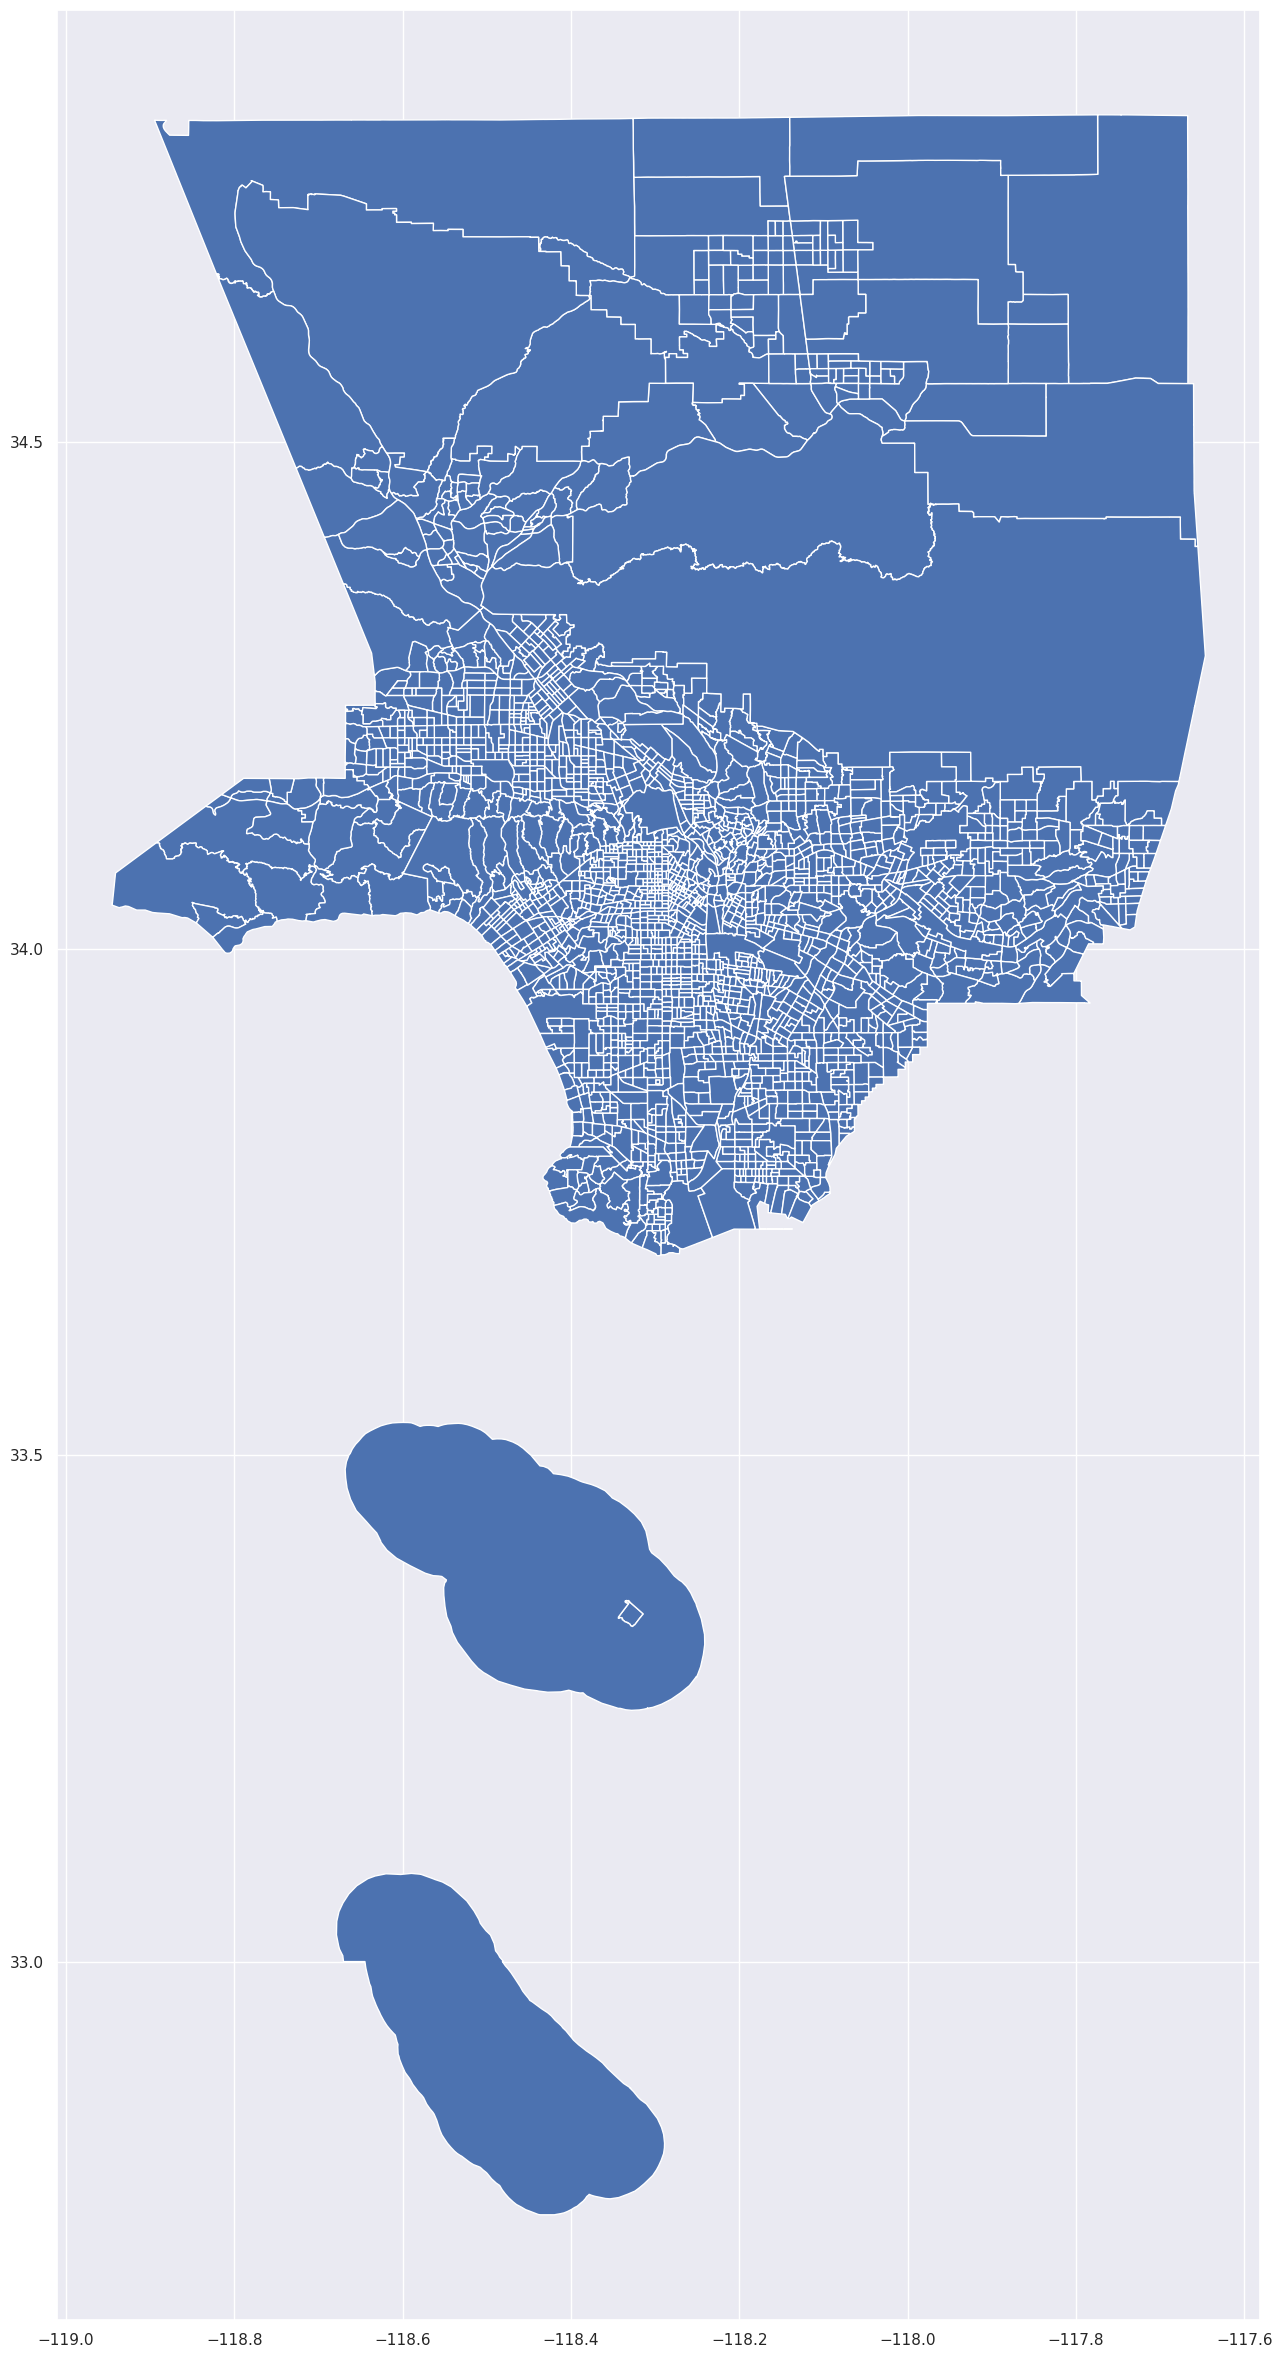

In [247]:
# first plot to see if things look alright
tracts.plot(figsize=(30,30))

In [248]:
# create FIPS column
tracts['fips'] ='06' + '037' + tracts['CT20']
tracts = tracts[['geometry','fips']]
tracts.head()

,geometry,fips
0,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110
1,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122
2,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220
3,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221
4,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222


In [249]:
df = df.rename({'Geo_FIPS': 'fips'}, axis=1)
df.head()

,fips,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
0,06037101110,644,438,0,0,58,0,52,96,372,207,3879,0.549689
1,06037101122,344,287,0,0,0,0,33,24,287,33,4247,0.706395
2,06037101220,762,450,8,16,48,0,110,130,394,285,3583,0.535433
3,06037101221,1140,815,68,0,25,0,178,54,747,269,3723,0.663158
4,06037101222,816,715,17,0,28,17,28,11,515,239,2690,0.651961


In [250]:
# create a new dataframe based on the join
tracts_rentburden=tracts.merge(df,on="fips")

In [251]:
# check if successful
tracts_rentburden.head()

,geometry,fips,total_housing_units,white_alone,black_alone,american_indian_alone,asian_alone,native_hawaiian_alone,other,two_or_more,white_alone_not_hisp,hispanic,total_pop,rent_burden
0,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110,644,438,0,0,58,0,52,96,372,207,3879,0.549689
1,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122,344,287,0,0,0,0,33,24,287,33,4247,0.706395
2,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220,762,450,8,16,48,0,110,130,394,285,3583,0.535433
3,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221,1140,815,68,0,25,0,178,54,747,269,3723,0.663158
4,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222,816,715,17,0,28,17,28,11,515,239,2690,0.651961


<AxesSubplot: >

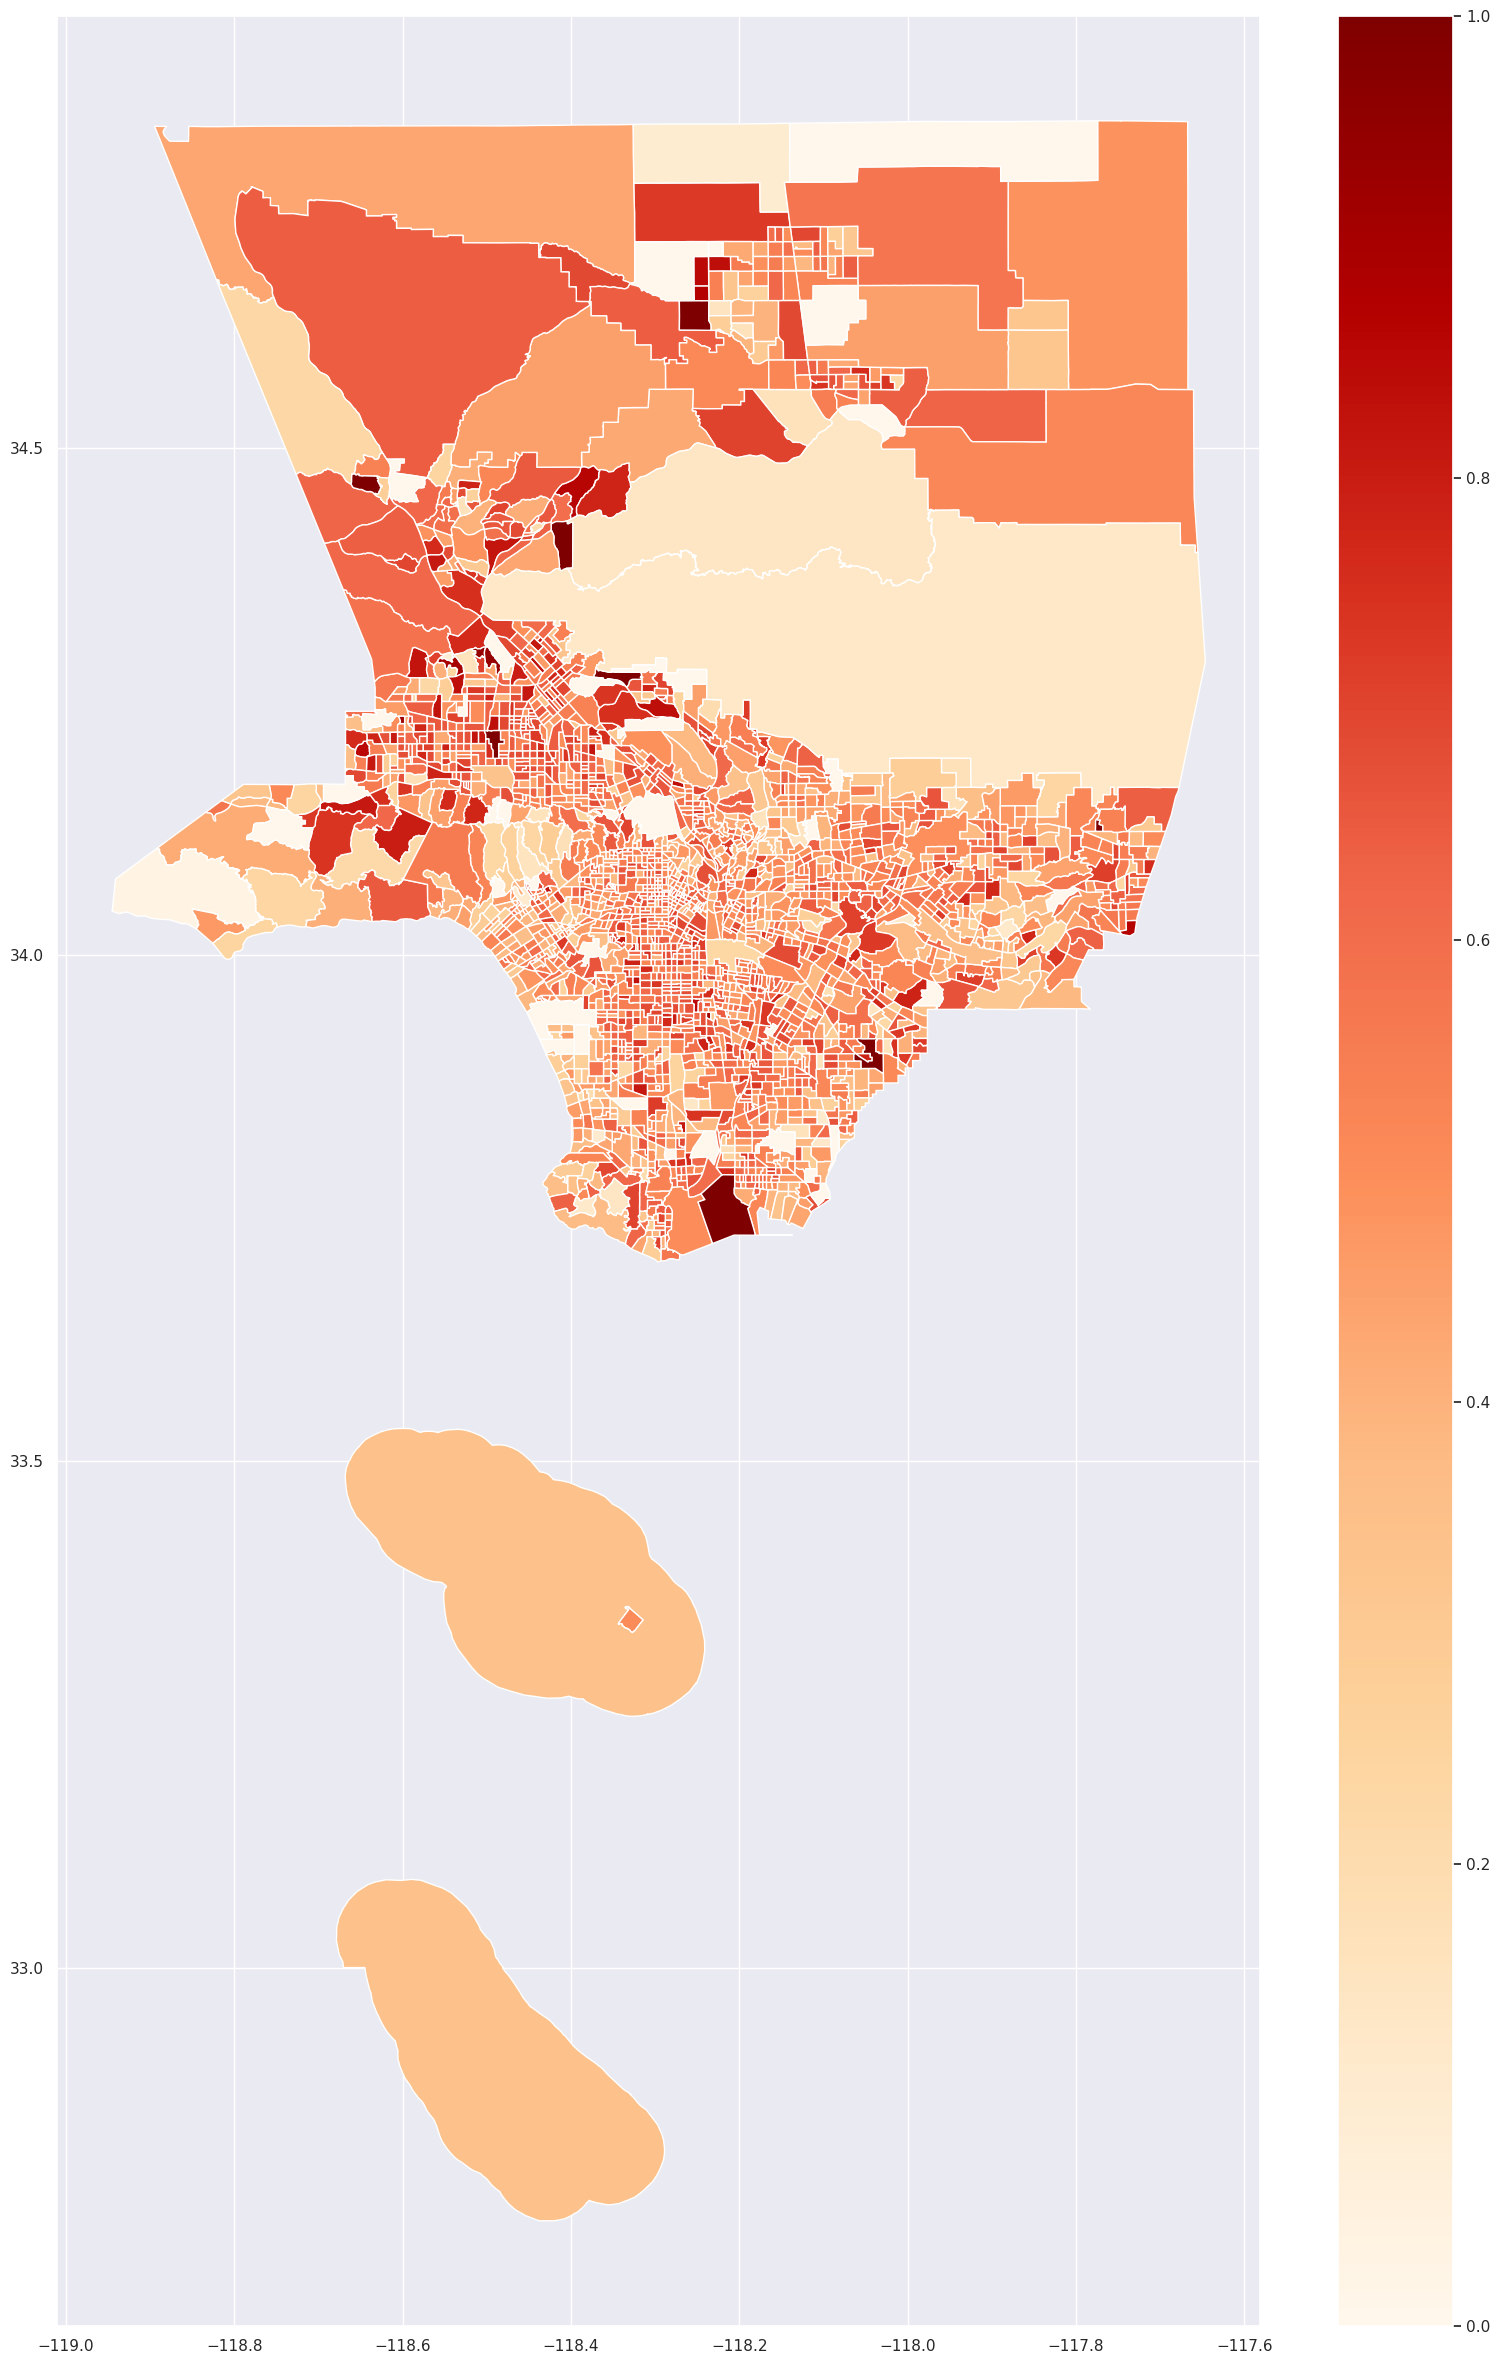

In [252]:
# lets plot rent burden values across census tracts in LA County
tracts_rentburden.plot(figsize=(20,30),
                 column='rent_burden',
                 legend=True, 
                      cmap = 'OrRd')

In [253]:
# lets see how we can visualize rent burden values for census tracts that have a disproportionate share of renter-occupied households for a particular race
tracts_rentburden_hispanic = tracts_rentburden[tracts_rentburden['hispanic'] > tracts_rentburden['white_alone']]
tracts_rentburden_white = tracts_rentburden[tracts_rentburden['hispanic'] < tracts_rentburden['white_alone']]
tracts_rentburden_black = tracts_rentburden[tracts_rentburden['black_alone'] > tracts_rentburden['white_alone']]

The average rent burden value for census tracts where hispanic renter-households outnumber white renter-households is 56.050140415499264


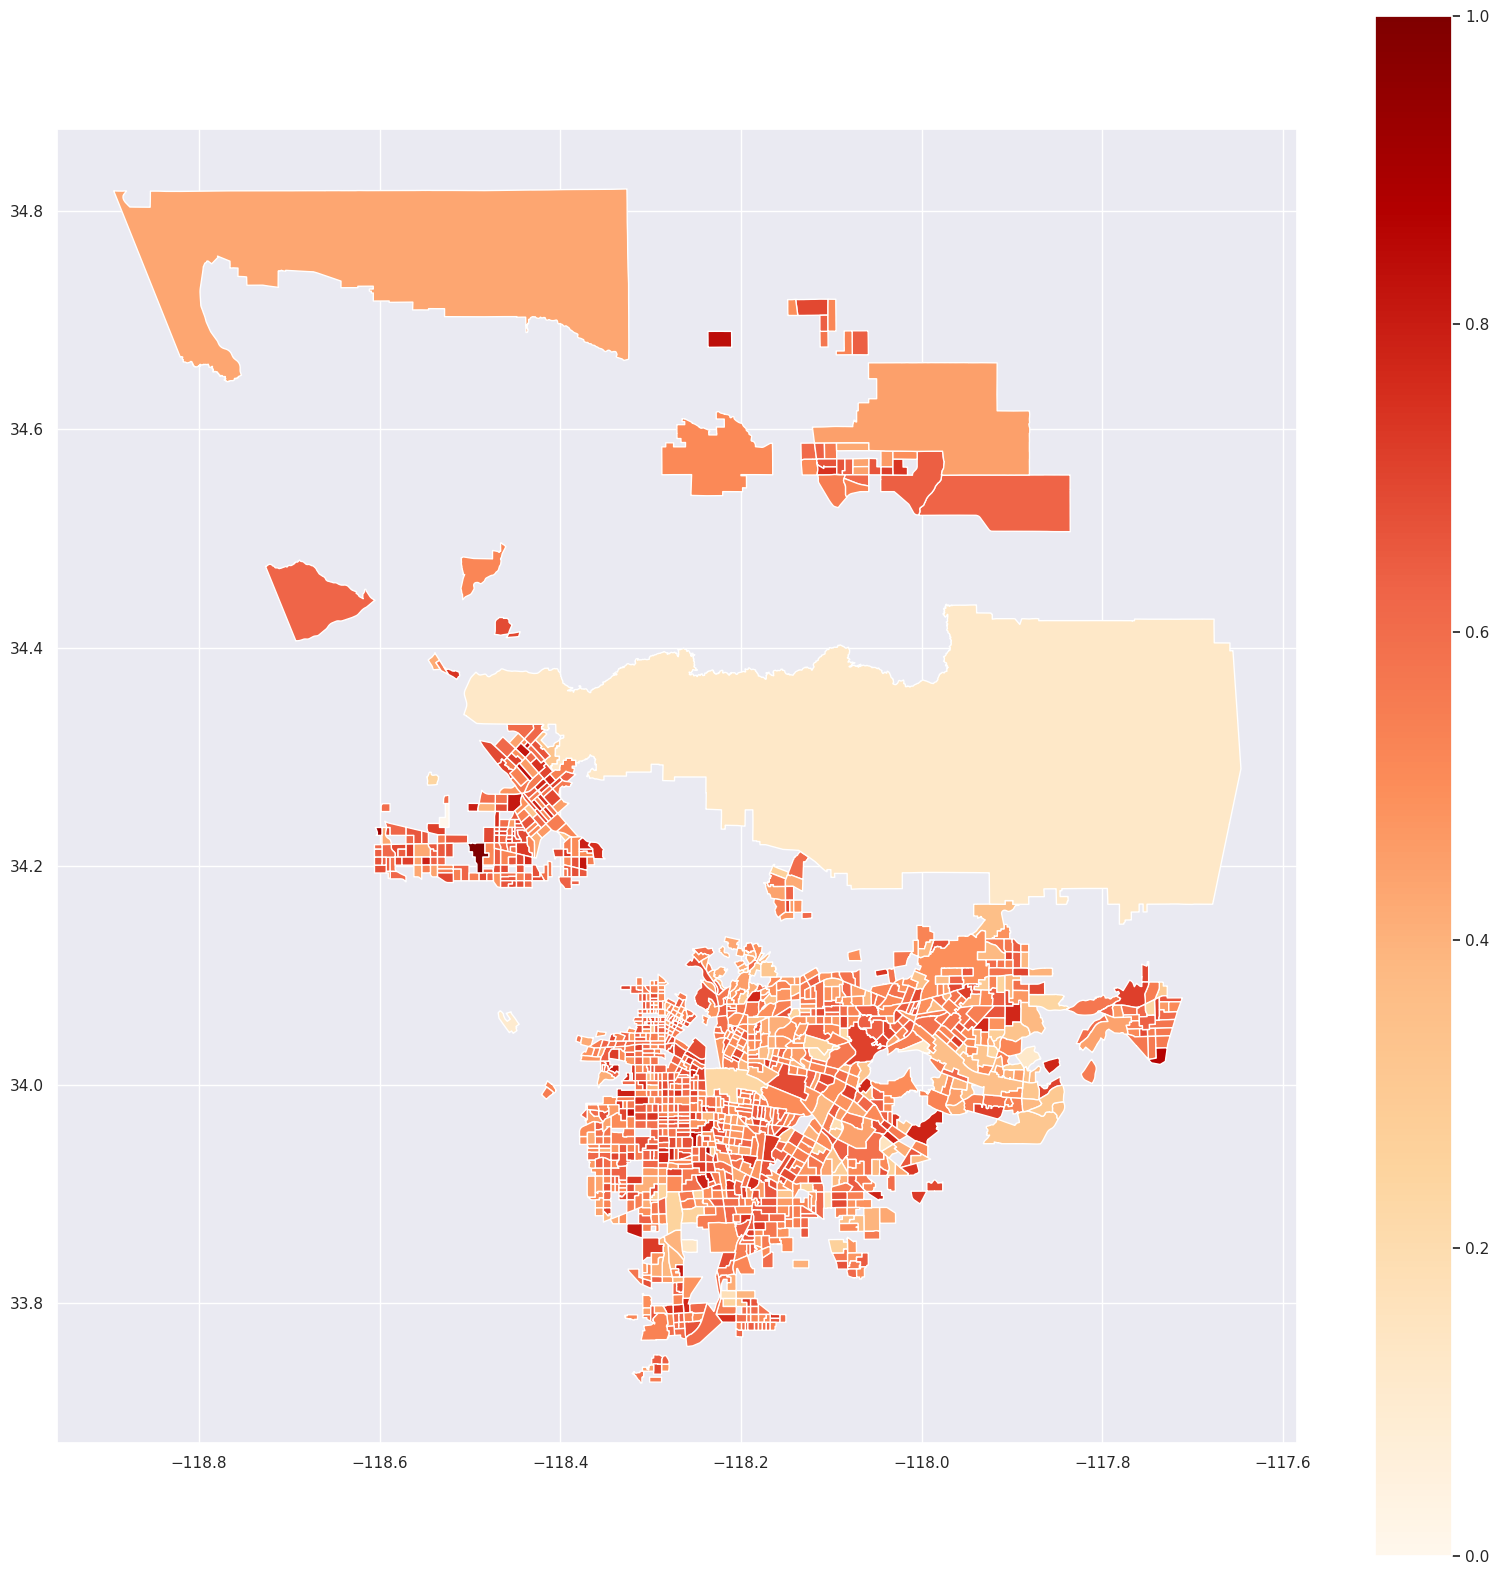

In [254]:
# plot census tracts where hispanic renter-households outnumber white renter-households
tracts_rentburden_hispanic.plot(figsize=(20,20),
                 column='rent_burden',
                 legend=True, 
                      cmap = 'OrRd')

print('The average rent burden value for census tracts where hispanic renter-households outnumber white renter-households is', tracts_rentburden_hispanic.rent_burden.mean()*100)

The average rent burden value for census tracts where white renter-households outnumber hispanic renter-households is 49.988086115058614


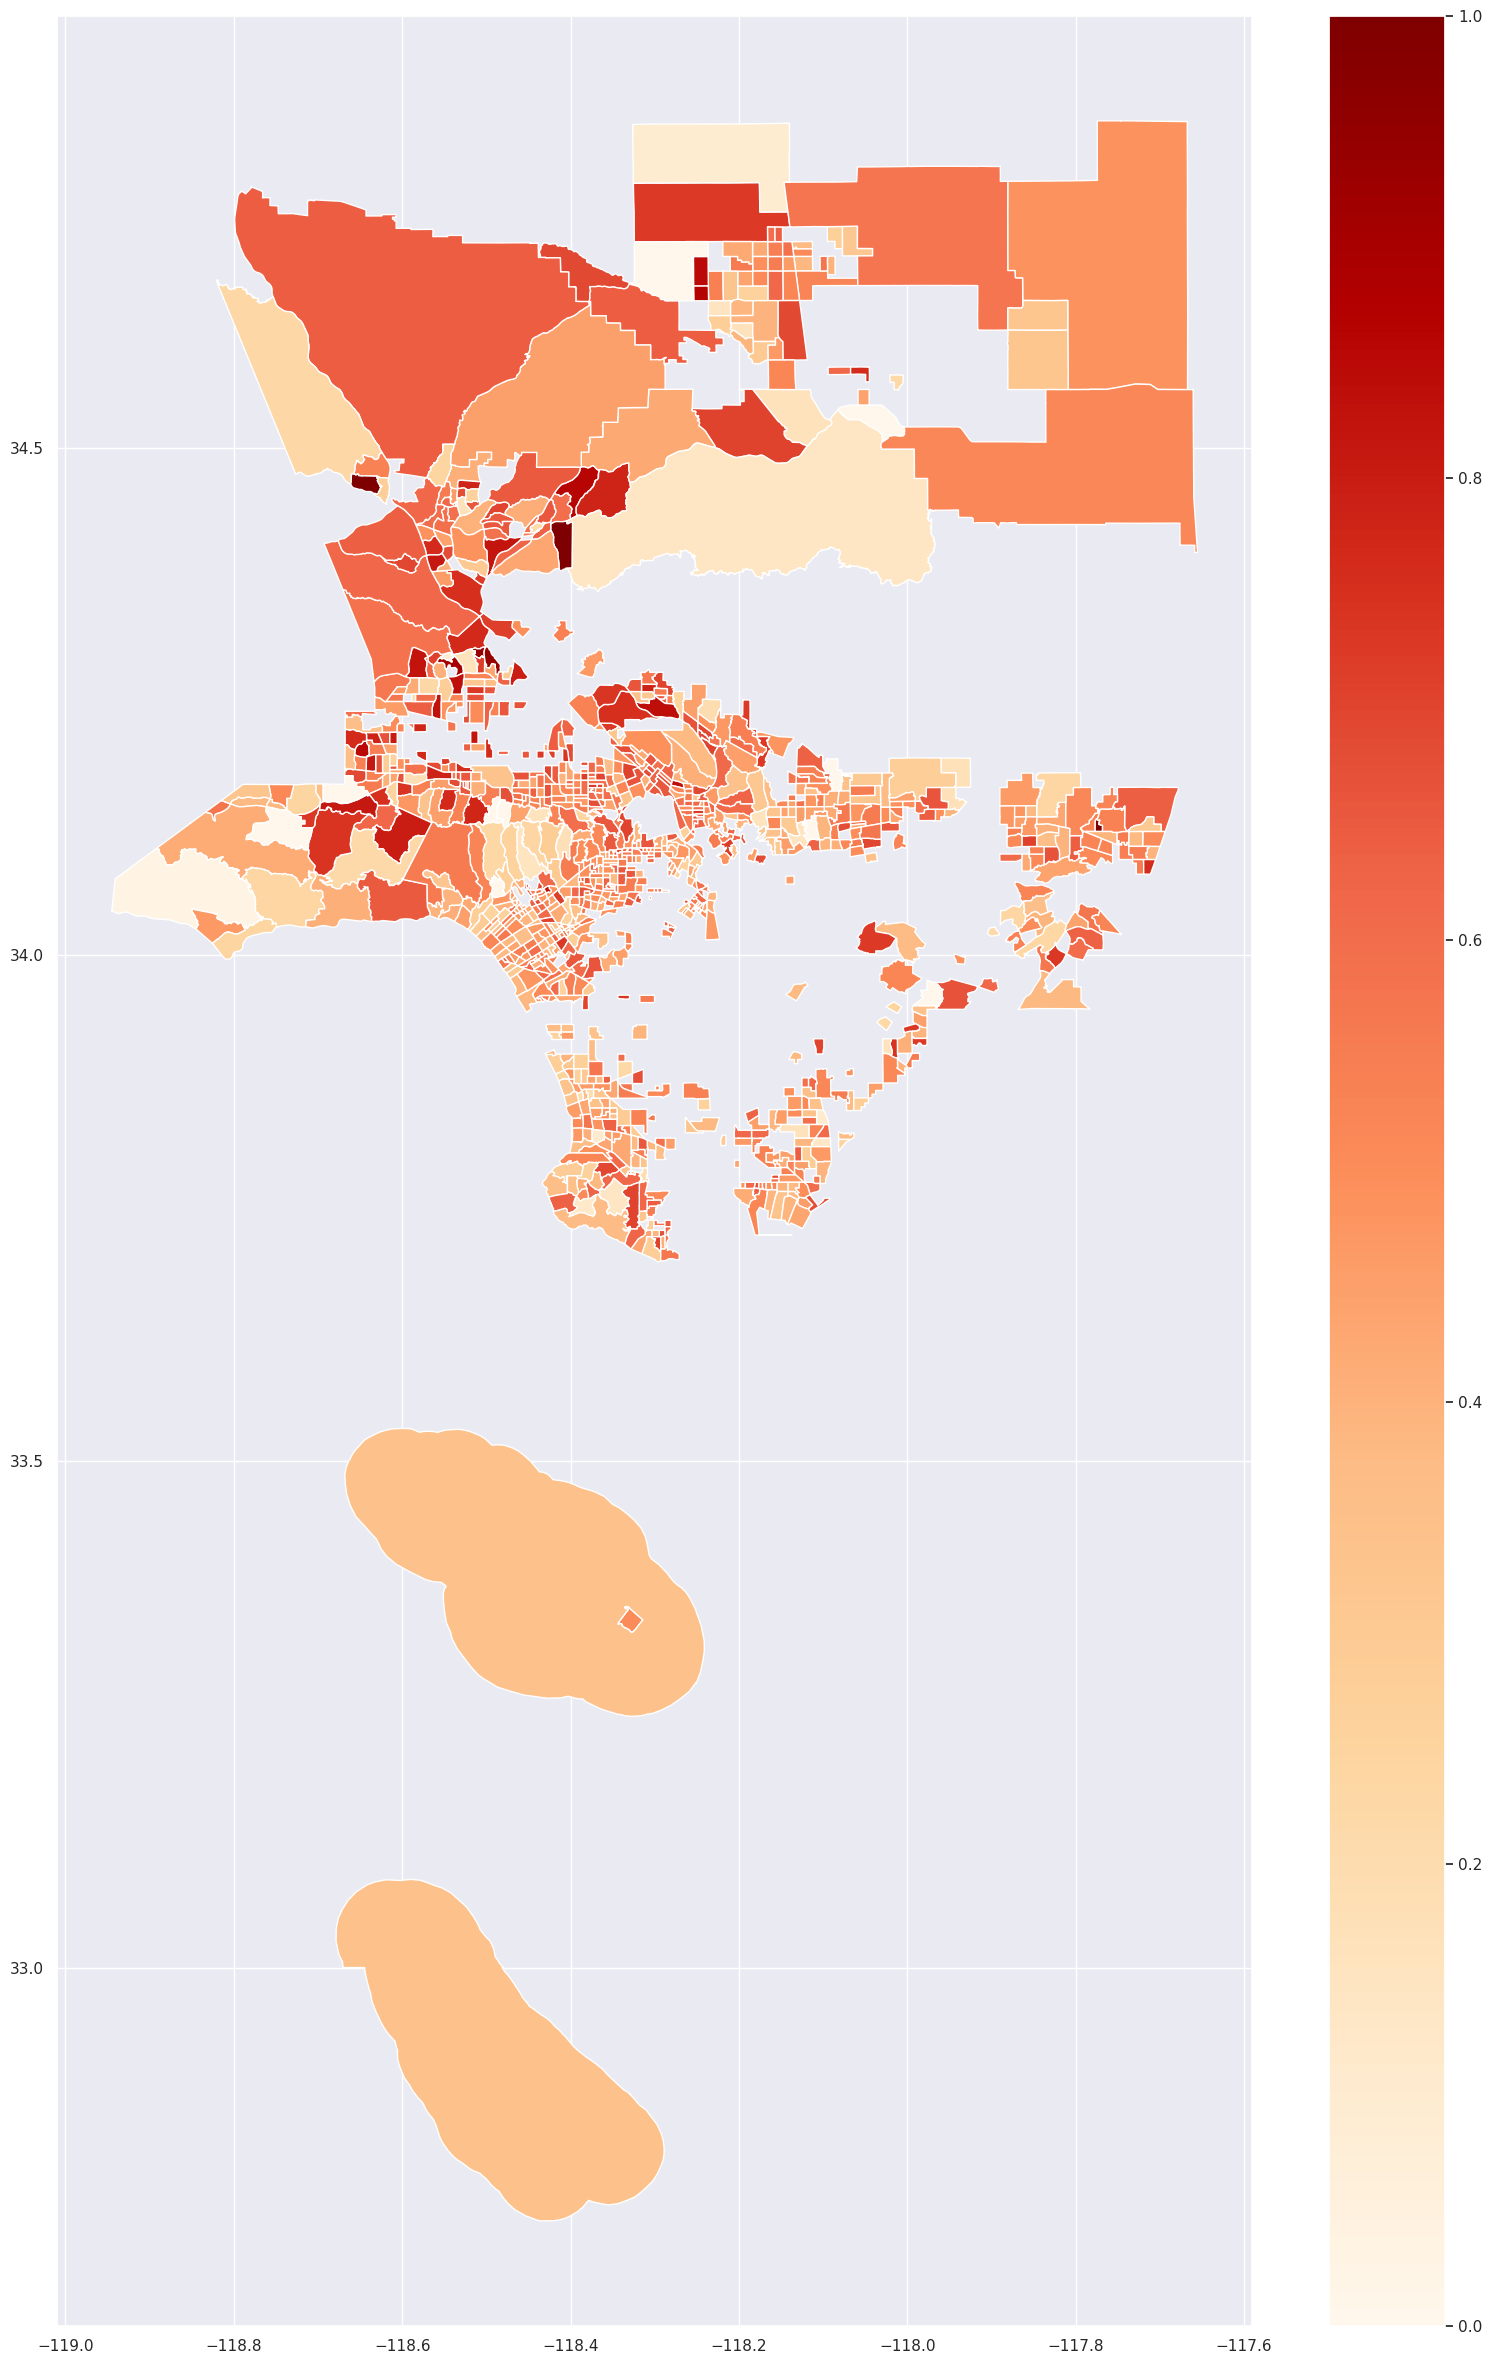

In [255]:
# plot census tracts where white renter-households outnumber hispanic renter-households
tracts_rentburden_white.plot(figsize=(20,30),
                 column='rent_burden',
                 legend=True, 
                      cmap = 'OrRd')

print('The average rent burden value for census tracts where white renter-households outnumber hispanic renter-households is', tracts_rentburden_white.rent_burden.mean()*100)

The average rent burden value for census tracts where black renter-households outnumber white renter-households is 56.25770548540926


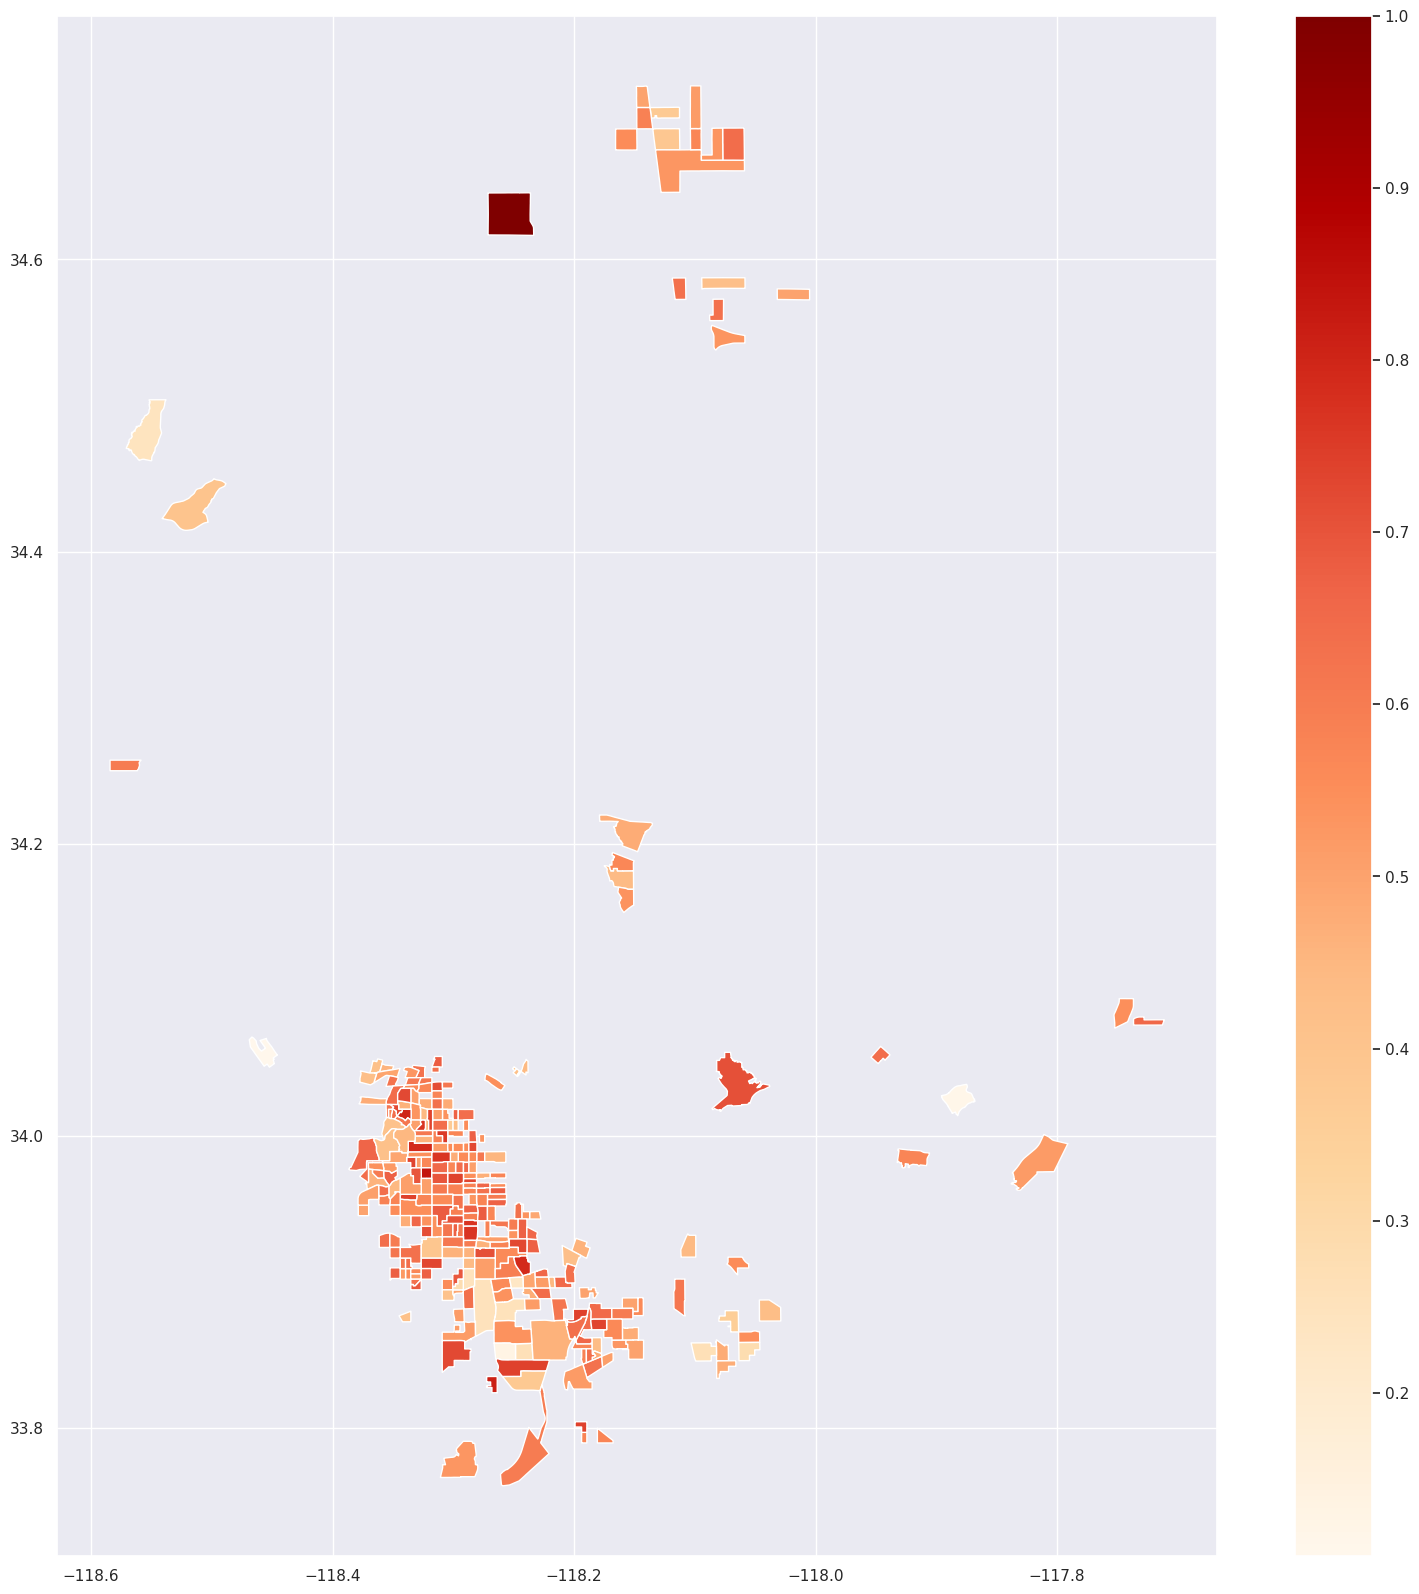

In [256]:
# plot census tracts where black renter-households outnumber white renter-households
tracts_rentburden_black.plot(figsize=(20,20),
                 column='rent_burden',
                 legend=True, 
                      cmap = 'OrRd')

print('The average rent burden value for census tracts where black renter-households outnumber white renter-households is', tracts_rentburden_black.rent_burden.mean()*100)

There does seem to be a relationship that we can visualize here based on the disparity of rent burden percentages of census tracts dominated by white renter-households and non-white renter households. The white census tracts are located closer to coastal areas and demonstrate lighter colors while the non-white census tracts are concentrated inland and toward downtown, demonstrating darker colors (with darker colors representing higher percentages of rent burden values).